In [1]:
# necessary imports
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


In [2]:
df=pd.read_csv('bitcoin_price.csv')

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


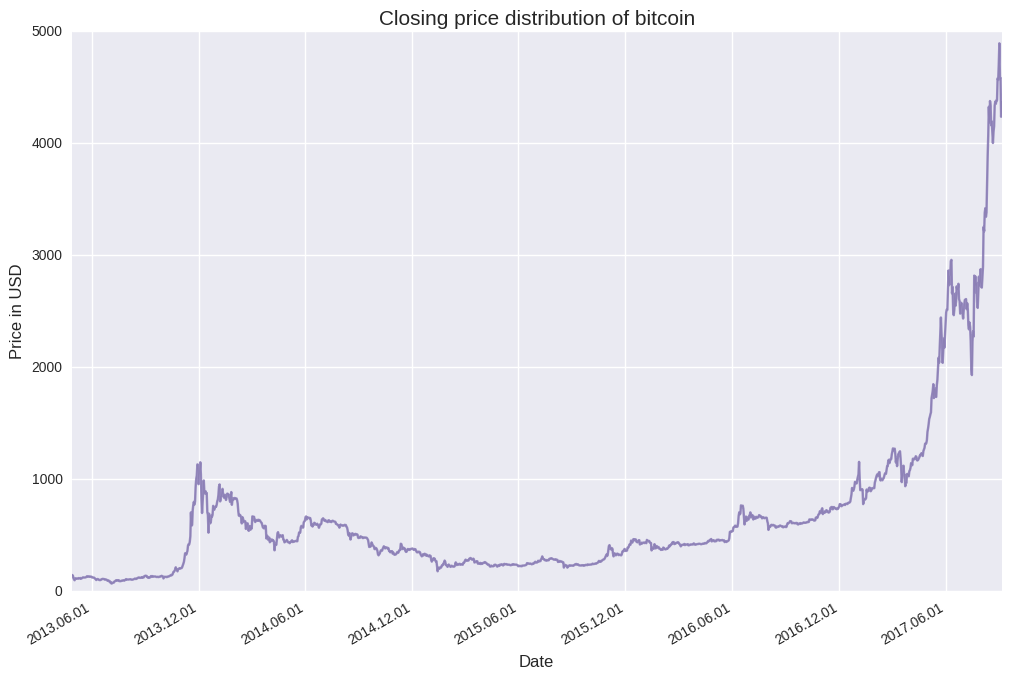

In [3]:
import matplotlib.dates as mdates
df['Date']=pd.to_datetime(df['Date'])
df['Date_mpl'] = df['Date'].apply(lambda x: mdates.date2num(x))

fig, ax = plt.subplots(figsize=(12,8))
sns.tsplot(df.Close.values, time=df.Date_mpl.values, alpha=0.8, color=color[3], ax=ax)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of bitcoin", fontsize=15)
plt.show()

In [4]:
df['day']=pd.to_datetime(df['Date']).dt.day
df['month']=pd.to_datetime(df['Date']).dt.month
df['year']=pd.to_datetime(df['Date']).dt.year
df['week']=pd.to_datetime(df['Date']).dt.week
df['Date']=pd.to_datetime(df['Date'])
df=df.sort_values(by='Date',ascending=True)

In [5]:
s = pd.Series(df['Close'].values, index=df.Date.values)

In [6]:
# computing exponential moving average
EWMA_upper=pd.ewma(s,span=20)
EWMA_lower=pd.ewma(s,span=5)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=20,min_periods=0,adjust=True).mean()
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=5,min_periods=0,adjust=True).mean()
  app.launch_new_instance()


In [7]:
# computing relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
         pd.stats.moments.ewma(d, com=period-1, adjust=False)
    return 100 - 100 / (1 + rs)
data = s
rsi=RSI( data,10 )

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=False,com=9).mean()


In [8]:
# Compute the Bollinger Bands 
def BBANDS(data, window):
    MA = data.Close.rolling(window).mean()
    SD = data.Close.rolling(window).std()
    data['UpperBB'] = MA + (2 * SD) 
    data['LowerBB'] = MA - (2 * SD)
    return data
bands=BBANDS(df,10)

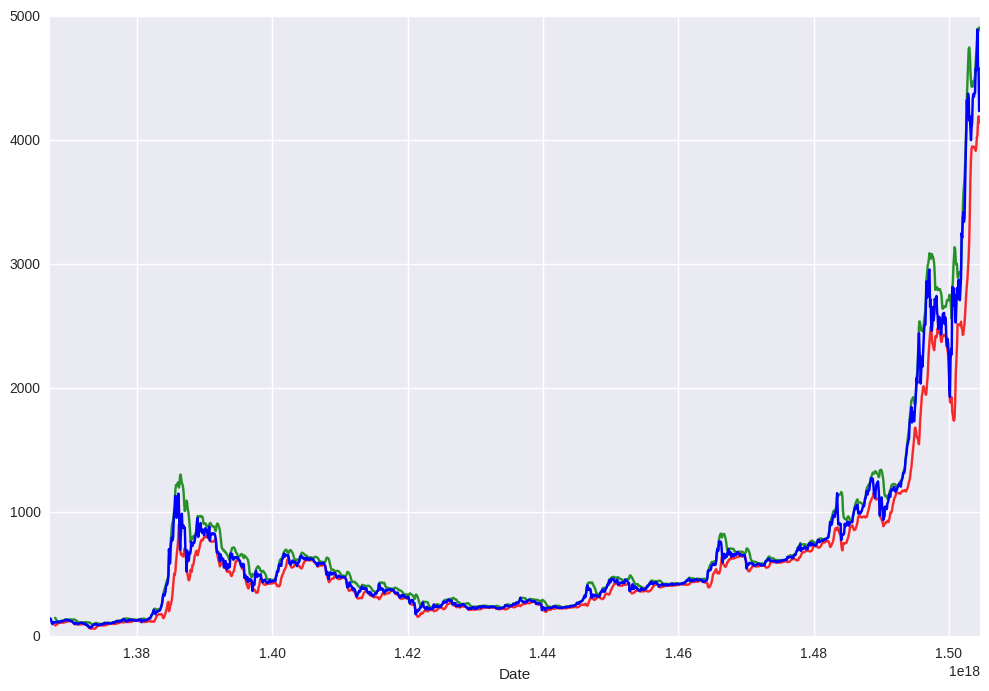

In [9]:
_BBAND1=pd.Series(data=bands['UpperBB'].values,index=bands['Date'])
_BBAND2=pd.Series(data=bands['LowerBB'].values,index=bands['Date'])
fig, ax = plt.subplots(figsize=(12,8))
sns.tsplot(_BBAND1, time=_BBAND1.index, alpha=0.8, color='g', ax=ax)
sns.tsplot(_BBAND2, time=_BBAND2.index, alpha=0.8, color='r', ax=ax)
sns.tsplot(s, time=s.index, alpha=1, color='b', ax=ax)

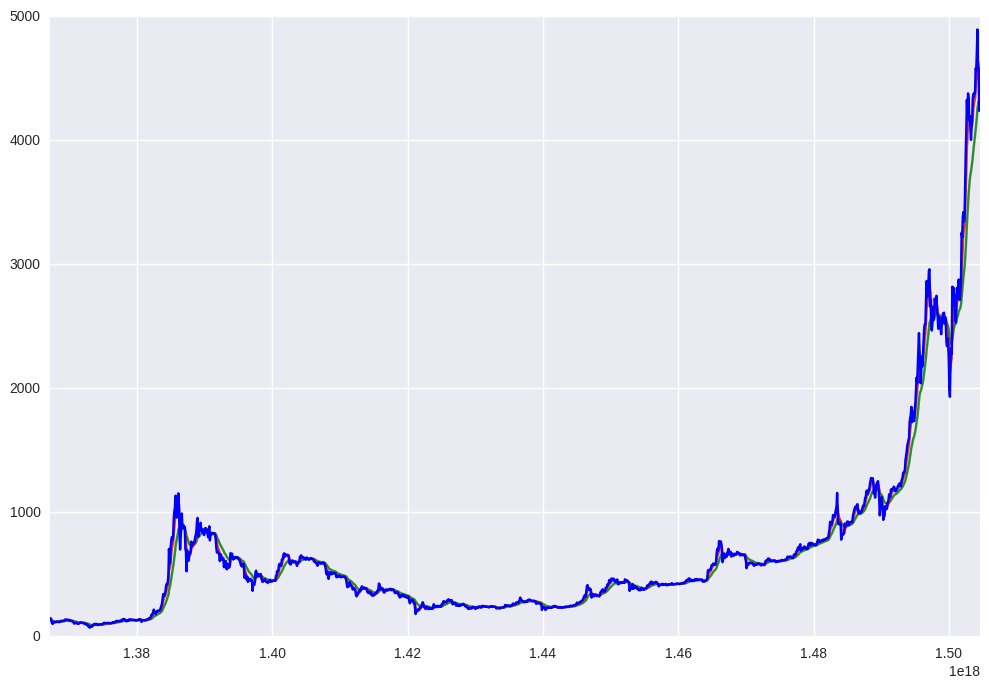

In [10]:
ew1=pd.Series(data=EWMA_upper.values,index=EWMA_upper.index)
ew2=pd.Series(data=EWMA_lower.values,index=EWMA_lower.index)
fig, ax = plt.subplots(figsize=(12,8))
sns.tsplot(ew1, time=ew1.index, alpha=0.8, color='g', ax=ax)
sns.tsplot(ew2, time=ew2.index, alpha=0.8, color='r', ax=ax)
sns.tsplot(s, time=s.index, alpha=1, color='b', ax=ax)

In [11]:
RSI=pd.DataFrame()
RSI['rsi']=rsi.values
RSI['Date']=rsi.index

In [12]:
EWMA_u=pd.DataFrame()
EWMA_u['ewma']=EWMA_upper.values
EWMA_u['Date']=EWMA_upper.index

In [13]:
EWMA_l=pd.DataFrame()
EWMA_l['ewma1']=EWMA_lower.values
EWMA_l['Date']=EWMA_lower.index

In [14]:
df=df.merge(RSI,on='Date')
df=df.merge(EWMA_u,on='Date')
df=df.merge(EWMA_l,on='Date')
df=df.merge(bands,on='Date')
df=df.dropna()

In [15]:
fdf=pd.DataFrame()
fdf['Close']=df['Close_x']
fdf['ewma_long']=df['ewma']
fdf['day']=df['day_x']
# fdf['month']=df['month']
fdf['week']=df['week_x']
# fdf['year']=df['year']
fdf['rsi']=df['rsi']
fdf['upperband']=df['UpperBB_x']
fdf['lowerband']=df['LowerBB_x']
fdf['ewma_short']=df['ewma1']

In [16]:
y=fdf['Close']
del fdf['Close']

In [17]:
X_train=fdf[0:1300]
y_train=y[0:1300]
X_test=fdf[1300:]
y_test=y[1300:]
from sklearn.preprocessing import MinMaxScaler,StandardScaler
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [18]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
import numpy as np
ndf=pd.DataFrame(index=y_test.index)
ndf['a']=(model.predict(X_test))

In [20]:
from sklearn.metrics import r2_score,mean_absolute_error
mean_absolute_error(y_test,model.predict(X_test))

35.182898918761452

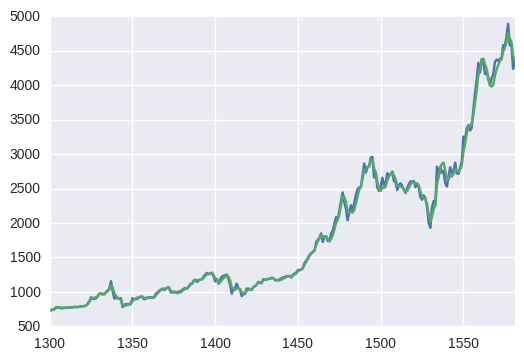

In [21]:
# blue plot reflects original closing values while green reflects predicted value
y_test.plot()
ndf['a'].plot()